In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader

torch.manual_seed(611)

In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [4]:
features = 'AI'#'PANNs'#'YAMNet' #'VGGish'#'AI'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

RZUA01
Data1.shape=torch.Size([3, 24, 60])
RZUA02
Data1.shape=torch.Size([3, 24, 60])
RZUA04
Data1.shape=torch.Size([3, 24, 60])
RZUA05
Data1.shape=torch.Size([3, 24, 60])
RZUA06
Data1.shape=torch.Size([3, 24, 60])
RZUA07
Data1.shape=torch.Size([3, 24, 60])
RZUA08
Data1.shape=torch.Size([3, 24, 60])
RZUA09
Data1.shape=torch.Size([3, 24, 60])
RZUA10
Data1.shape=torch.Size([3, 24, 60])
RZUB01
Data1.shape=torch.Size([3, 24, 60])
RZUB03
Data1.shape=torch.Size([3, 24, 60])
RZUB04
Data1.shape=torch.Size([3, 24, 60])
RZUB05
Data1.shape=torch.Size([3, 24, 60])
RZUB06
Data1.shape=torch.Size([3, 24, 60])
RZUB07
Data1.shape=torch.Size([3, 24, 60])
RZUB08
Data1.shape=torch.Size([3, 24, 60])
RZUB09
Data1.shape=torch.Size([3, 24, 60])
RZUB10
Data1.shape=torch.Size([3, 24, 60])
RZUB11
Data1.shape=torch.Size([3, 24, 60])
RZUC01
Data1.shape=torch.Size([3, 24, 60])
RZUC02
Data1.shape=torch.Size([3, 24, 60])
RZUC03
Data1.shape=torch.Size([3, 24, 60])
RZUC05
Data1.shape=torch.Size([3, 24, 60])
RZUC06
Data

In [6]:
def min_max_normalize_along_dim(tensor, dim):
    # Get min and max values along the specified dimension, keeping dimensions
    min_vals, _ = torch.min(tensor, dim=dim, keepdim=True)
    max_vals, _ = torch.max(tensor, dim=dim, keepdim=True)
    
    # Handle the case where min and max are the same (to avoid division by zero)
    diff = max_vals - min_vals
    diff[diff == 0] = 1.0  # Replace zeros with ones to avoid division by zero
    
    # Normalize the tensor
    normalized = (tensor - min_vals) / diff
    
    return normalized

In [7]:
x = min_max_normalize_along_dim(x, dim=2)
x.shape

torch.Size([3, 92, 24, 60])

## Edge Creation

In [8]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [9]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=5)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

max_nodes = max([data.num_nodes for data in graphs])
num_feat = graphs[0].x.shape[-1]
num_feat

Is the graph Data(x=[92, 24, 60], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 606]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 606]) connected? True
Is the graph undirected True


60

In [10]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

In [11]:
del graphs, x, unpacked_data, train_dataset

## Crear modelo y entrenar

In [12]:
from models import MatrixGCNVAE, MatrixGATVAE

In [13]:
model = MatrixGCNVAE(in_channels=64*num_feat, hidden_channels=4*num_feat, latent_dim=int(num_feat/8), num_nodes=max_nodes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.01 GCN

# Training function
def train():
    model.train()
    model.double()
    for graph in train_loader:
        optimizer.zero_grad()
        node_reconstruction, adj_reconstruction, mu, logvar = model(graph.x.double(), graph.edge_index)
        loss, feature_loss, adj_loss, kl_loss = model.loss_function(node_reconstruction, adj_reconstruction, graph.x.double(),
                                                                    graph.edge_index, mu, logvar, alpha=1.0, beta=0.1)
        loss.backward()
        optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 101):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 020, Loss: 0.9415
Epoch: 040, Loss: 0.7993
Epoch: 060, Loss: 0.7787
Epoch: 080, Loss: 0.7731
Epoch: 100, Loss: 0.7712


In [14]:
# Generate embeddings
model.eval()
with torch.no_grad():
    for graph in train_loader:
        _, _, mu, logvar = model(graph.x.double(), graph.edge_index)
        embeddings = model.reparameterize(mu, logvar)

In [15]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 7])


In [16]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

## Matriz de similitud

In [17]:
embs = embeddings.numpy()
sim_mat = (embs@embs.T)/num_feat
sim_mat

array([[0.02834994, 0.02295197, 0.02883359, ..., 0.02571684, 0.02493881,
        0.02381795],
       [0.02295197, 0.02326161, 0.0252166 , ..., 0.02316317, 0.02287548,
        0.02332684],
       [0.02883359, 0.0252166 , 0.03897716, ..., 0.03116817, 0.02672046,
        0.02833534],
       ...,
       [0.02571684, 0.02316317, 0.03116817, ..., 0.0282007 , 0.02445255,
        0.02375443],
       [0.02493881, 0.02287548, 0.02672046, ..., 0.02445255, 0.02905938,
        0.02725581],
       [0.02381795, 0.02332684, 0.02833534, ..., 0.02375443, 0.02725581,
        0.03050581]])

In [18]:
# norms = np.linalg.norm(embs, axis=1)
# sim_mat = embs @ embs.T / (norms[:, np.newaxis] @ norms[np.newaxis, :])
# sim_mat

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

In [20]:
adj_graph = edge_index_to_adjacency(graph.edge_index)

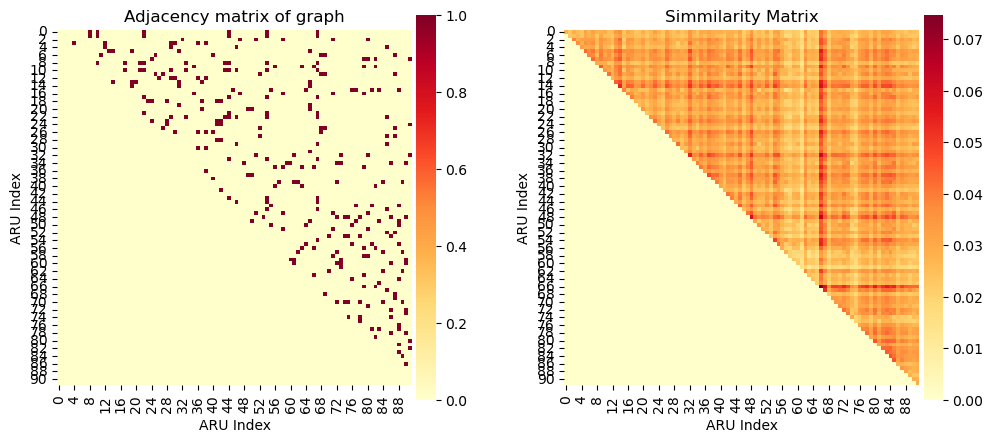

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(np.triu(adj_graph, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(np.triu(sim_mat, k=0), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Simmilarity Matrix')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

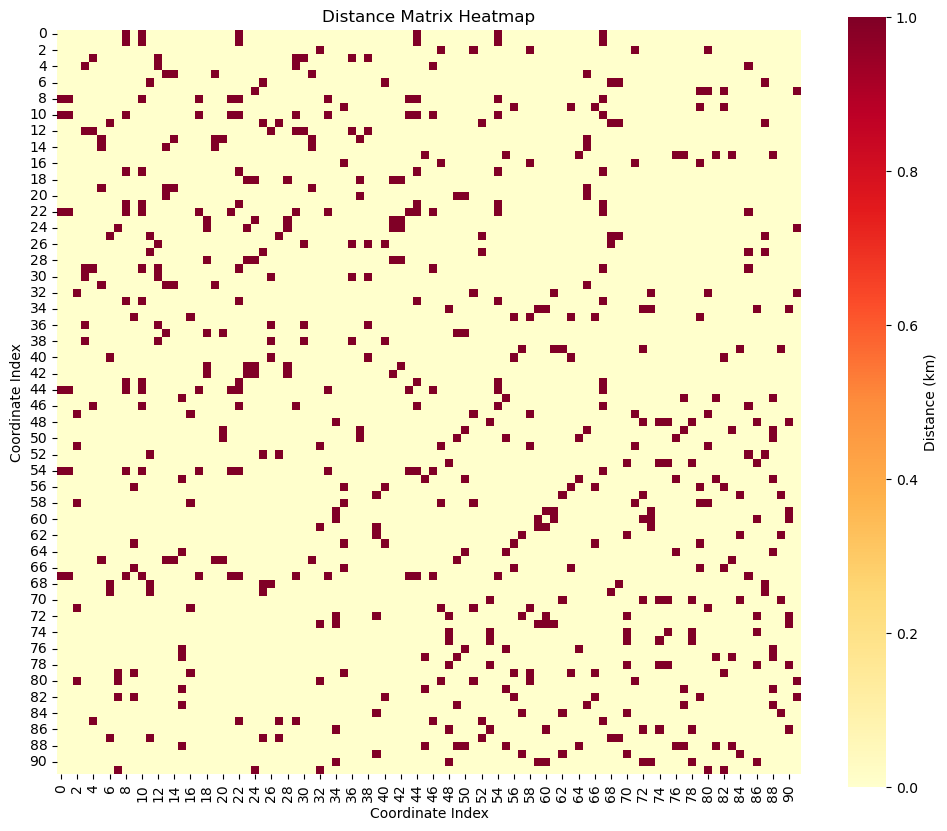

In [22]:
plot_distance_matrix_heatmap(adj_graph)

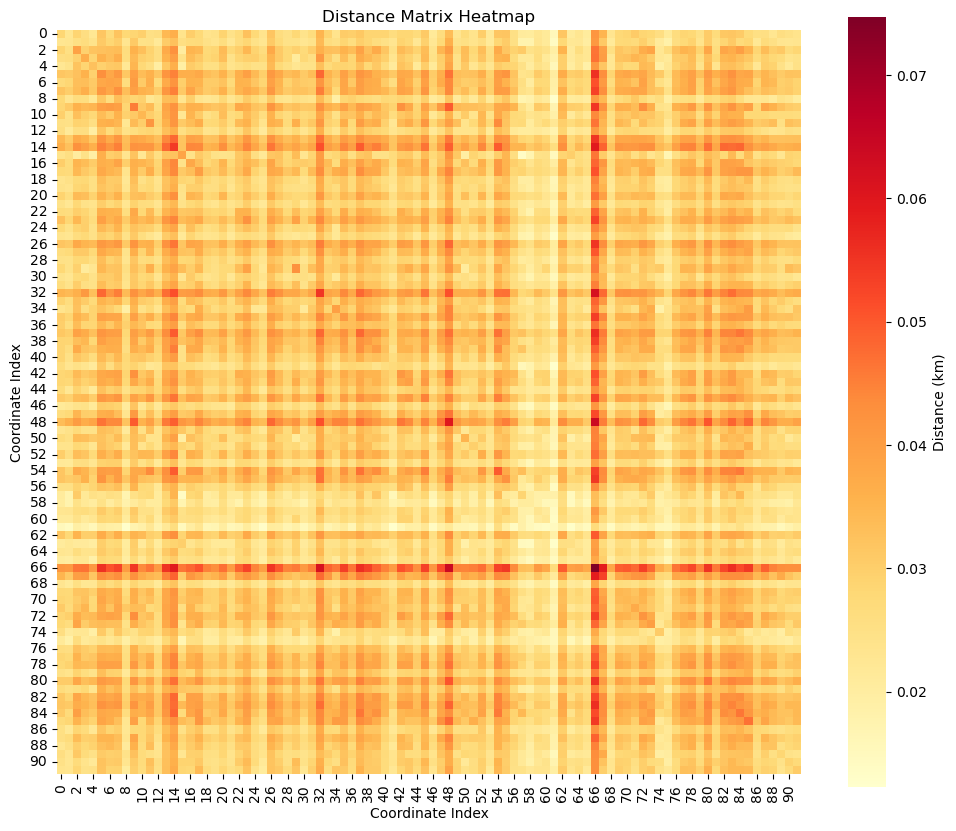

In [23]:
plot_distance_matrix_heatmap(sim_mat)

In [24]:
# density metric:

print(np.mean(sim_mat)) #axis = 0: por nodos

0.030700470940961663


In [25]:
# connectivity metric (only if thresholded):

print(np.count_nonzero(sim_mat))

8464


In [26]:
# total weight (es density sin promediar)

print(np.sum(sim_mat))

259.8487860442995


In [27]:
def floyd_warshall(matrix):
    """Implement Floyd-Warshall algorithm for all-pairs shortest paths"""
    n = len(matrix)
    dist = np.array(matrix, dtype=float)
    
    # Replace inf with large number for calculations
    dist[dist == float('inf')] = 1e9
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    
    return dist

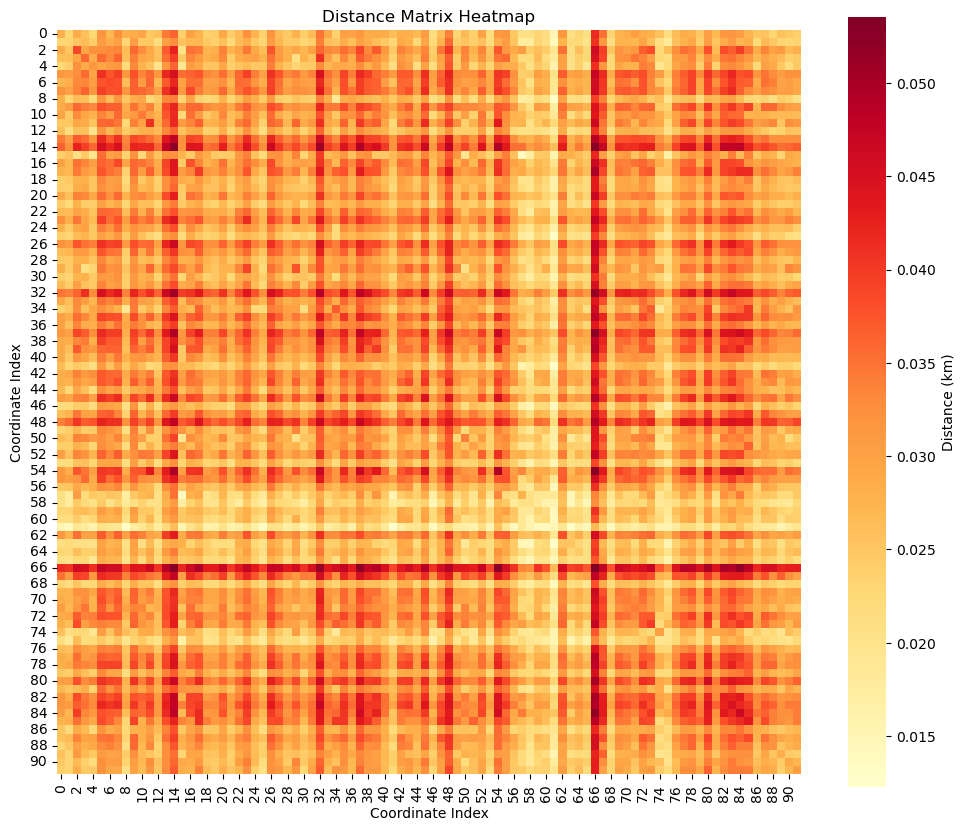

In [28]:
dist_matrix = floyd_warshall(sim_mat)
plot_distance_matrix_heatmap(dist_matrix)

In [29]:
# diameter
print(np.max(dist_matrix))

0.05354142378014655


In [30]:
#average path
print(np.mean(dist_matrix))

0.030563345137208424


In [31]:
#Betweeness centrality

n = len(dist_matrix)
centrality = np.zeros(n)
for s in range(n):
    for t in range(n):
        if s != t:
            # Count shortest paths going through each vertex
            for v in range(n):
                if v != s and v != t:
                    if dist_matrix[s][t] == dist_matrix[s][v] + dist_matrix[v][t]:
                        centrality[v] += 1
value = np.mean(centrality)
print(value)

4.456521739130435


In [32]:
dist_matrix

array([[0.02834994, 0.02295197, 0.02883359, ..., 0.02571684, 0.02493881,
        0.02381795],
       [0.02295197, 0.02326161, 0.0252166 , ..., 0.02316317, 0.02287548,
        0.02332684],
       [0.02883359, 0.0252166 , 0.03871247, ..., 0.03116817, 0.02672046,
        0.02833534],
       ...,
       [0.02571684, 0.02316317, 0.03116817, ..., 0.0282007 , 0.02445255,
        0.02375443],
       [0.02493881, 0.02287548, 0.02672046, ..., 0.02445255, 0.02905938,
        0.02725581],
       [0.02381795, 0.02332684, 0.02833534, ..., 0.02375443, 0.02725581,
        0.03050581]])

## New tests

In [33]:
graphs_ = edge_creation_nodeinfo(embeddings.unsqueeze(0),'knn', k_neigh=5)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 7], edge_index=[2, 654]) connected? True
Is the graph undirected True


In [34]:
adj_init = edge_index_to_adjacency(graph.edge_index)
adj_final = edge_index_to_adjacency(graphs_[0].edge_index)

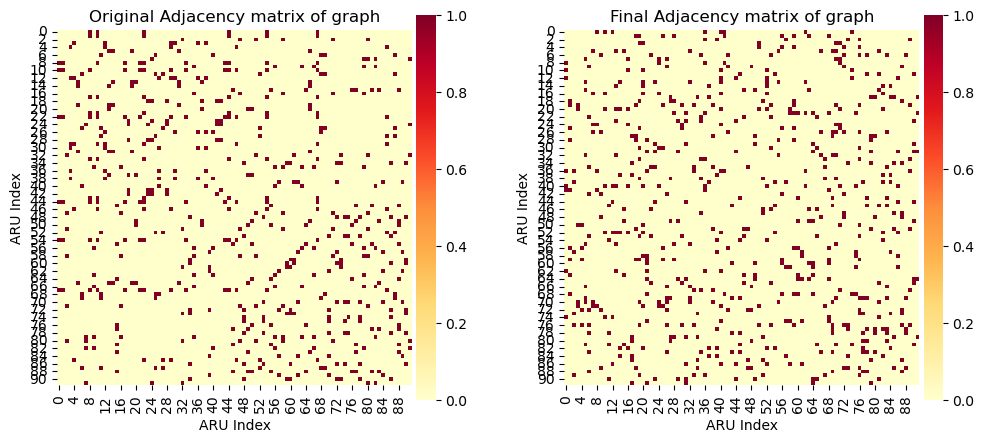

In [35]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(adj_init, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Original Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(adj_final, cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Final Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

In [36]:
graphs_[0]

Data(x=[92, 7], edge_index=[2, 654])

In [37]:
graph

DataBatch(x=[92, 24, 60], edge_index=[2, 606], batch=[92], ptr=[2])

In [38]:
def pyg_to_networkx(data):
    # Convert PyG data to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges with weights if available
    edges = data.edge_index.t().numpy()
    
    # Check if edge weights are available
    if hasattr(data, 'edge_weight') and data.edge_weight is not None:
        # Add edges with weights
        edge_weights = {tuple(edge): weight.item() for edge, weight in zip(edges, data.edge_weight)}
        for edge, weight in edge_weights.items():
            G.add_edge(edge[0], edge[1], weight=weight)
    else:
        # Add edges without weights
        G.add_edges_from(edges)
    
    # Optionally add node and edge attributes
    if data.x is not None:
        nx.set_node_attributes(G, {i: data.x[i].numpy() for i in range(data.num_nodes)}, 'features')
    
    if data.edge_attr is not None:
        edge_attrs = {tuple(edge): data.edge_attr[i].numpy() for i, edge in enumerate(edges)}
        nx.set_edge_attributes(G, edge_attrs, 'attributes')
    
    return G

In [39]:
import geopandas as gpd

#función que permite plotear nodos en posición geográfica deseada
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud_IG, df.latitude_IG)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

coordinates = same_posicion_data(df_map)

In [40]:
def adjacency_to_edge_weights(adj_matrix, edge_index):
    """
    Convert adjacency matrix of weights to edge_weight tensor using edge_index.
    
    Args:
        adj_matrix: Tensor of shape [num_nodes, num_nodes] containing edge weights
        edge_index: Tensor of shape [2, num_edges] containing edge indices
        
    Returns:
        edge_weight: Tensor of shape [num_edges] containing weights for each edge
    """
    # Get source and target nodes for each edge
    src, dst = edge_index[0], edge_index[1]
    
    # Extract weights from adjacency matrix based on edge indices
    edge_weight = adj_matrix[src, dst]
    
    return edge_weight

In [41]:
edge_weight = adjacency_to_edge_weights(sim_mat, graphs_[0].edge_index)
edge_weight.shape


(654,)

In [42]:
graphs_[0].edge_weight = edge_weight

In [43]:
sim_mat.shape

(92, 92)

In [44]:
import networkx as nx

G = pyg_to_networkx(graphs_[0])
nodes = list(G.nodes())
positions = dict(zip(G.nodes, coordinates))

In [45]:
G.edges(data=True)

EdgeDataView([(0, 8, {'weight': 0.028100618070060243}), (0, 10, {'weight': 0.029795704498629498}), (0, 12, {'weight': 0.025883194700787385}), (0, 36, {'weight': 0.029869498763177894}), (0, 40, {'weight': 0.0286964847629994}), (0, 41, {'weight': 0.026403365350574297}), (0, 62, {'weight': 0.031546404027840584}), (0, 74, {'weight': 0.02574991921270018}), (1, 18, {'weight': 0.024737440862705014}), (1, 19, {'weight': 0.023658177392481907}), (1, 25, {'weight': 0.022868613362047884}), (1, 28, {'weight': 0.024598634665804402}), (1, 41, {'weight': 0.023040631379023416}), (1, 56, {'weight': 0.025166630115961045}), (1, 59, {'weight': 0.023151520655158003}), (1, 63, {'weight': 0.022155399748835975}), (1, 68, {'weight': 0.02142829423264884}), (2, 36, {'weight': 0.033577079658226046}), (2, 39, {'weight': 0.037205388094482844}), (2, 57, {'weight': 0.03065136717498138}), (2, 73, {'weight': 0.038369768387396454}), (2, 76, {'weight': 0.032564057186292135}), (2, 89, {'weight': 0.031168171949502926}), (3,

In [46]:
nx.diameter(G,weight="weight")

0.17733936855072238

In [47]:
nx.density(G)

0.07811753463927378

In [48]:
nx.average_shortest_path_length(G,weight="weight")

0.0866988413184579

In [49]:
nx.betweenness_centrality(G, weight="weight")

{0: 0.011965811965811965,
 1: 0.041758241758241756,
 2: 0.018803418803418803,
 3: 0.007814407814407814,
 4: 0.010744810744810745,
 5: 0.014163614163614164,
 6: 0.018803418803418803,
 7: 0.003663003663003663,
 8: 0.003663003663003663,
 9: 0.0,
 10: 0.001221001221001221,
 11: 0.00927960927960928,
 12: 0.013186813186813187,
 13: 0.01733821733821734,
 14: 0.0017094017094017094,
 15: 0.006349206349206349,
 16: 0.004151404151404151,
 17: 0.015384615384615385,
 18: 0.040293040293040296,
 19: 0.05860805860805861,
 20: 0.040048840048840045,
 21: 0.07594627594627594,
 22: 0.0019536019536019536,
 23: 0.010500610500610501,
 24: 0.026617826617826617,
 25: 0.012942612942612942,
 26: 0.020512820512820513,
 27: 0.029304029304029304,
 28: 0.024175824175824177,
 29: 0.0,
 30: 0.019291819291819293,
 31: 0.020757020757020756,
 32: 0.0,
 33: 0.007326007326007326,
 34: 0.005128205128205128,
 35: 0.015873015873015872,
 36: 0.028815628815628817,
 37: 0.0,
 38: 0.006593406593406593,
 39: 0.017826617826617826,


In [50]:
[sim_mat[u,v] for u, v in G.edges()]

[0.028100618070060243,
 0.029795704498629498,
 0.025883194700787385,
 0.029869498763177894,
 0.0286964847629994,
 0.026403365350574297,
 0.031546404027840584,
 0.02574991921270018,
 0.024737440862705014,
 0.023658177392481907,
 0.022868613362047884,
 0.024598634665804402,
 0.023040631379023416,
 0.025166630115961045,
 0.023151520655158003,
 0.022155399748835975,
 0.02142829423264884,
 0.033577079658226046,
 0.037205388094482844,
 0.03065136717498138,
 0.038369768387396454,
 0.032564057186292135,
 0.031168171949502926,
 0.02903203070241432,
 0.0331084013846169,
 0.03311221958235017,
 0.03262988957819228,
 0.03472303033783844,
 0.031088274740060533,
 0.028376037579579273,
 0.02483210360783816,
 0.03419271499295209,
 0.029332547583935095,
 0.04102218729324758,
 0.04195637648252394,
 0.036221820824085135,
 0.04798264597566697,
 0.041996542600261796,
 0.05560981153901056,
 0.03732677274199763,
 0.038145226385993485,
 0.035922400642762004,
 0.04035993347459788,
 0.0356607435877788,
 0.038120

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


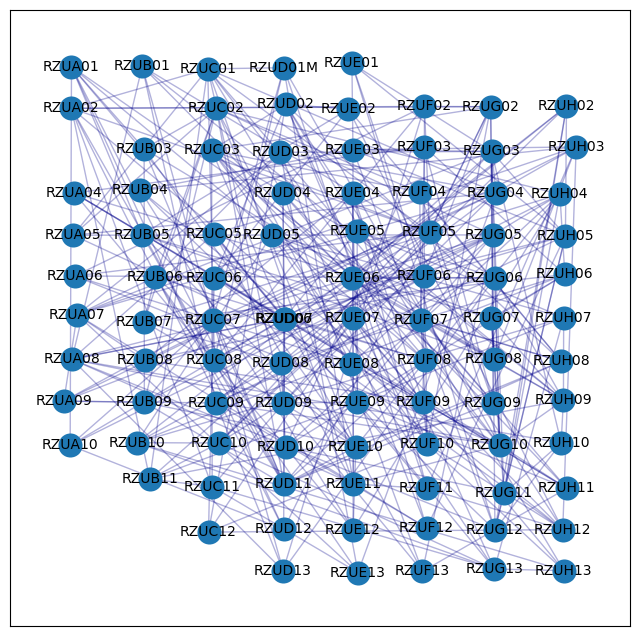

In [51]:
edge_weights = [1 for u, v in G.edges()]
# edge_weights = [sim_mat[u,v]  for u, v in G.edges()]

# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
# node_color = colores
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo


# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.3) # se puede ver tambien con colores cambiando edge_color=edge_colors
# fig.savefig('./results/graph_geo.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)

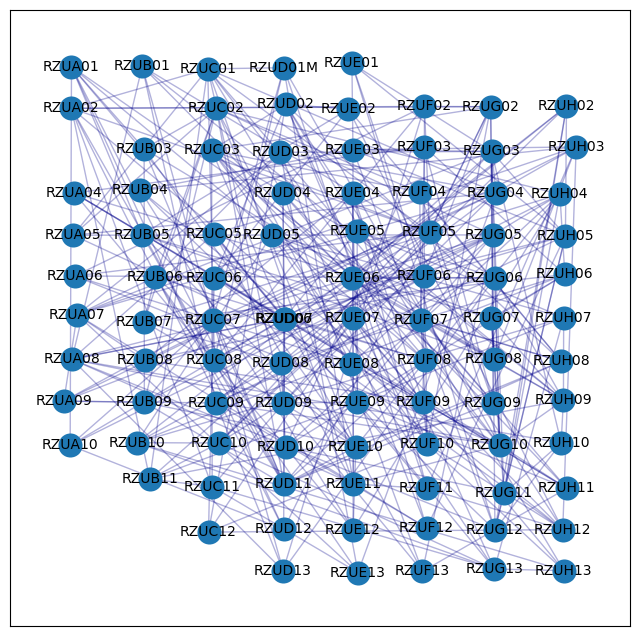

In [52]:
edge_weights = [1 for u, v in G.edges()]

# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
# node_color = colores
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo


# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.3) # se puede ver tambien con colores cambiando edge_color=edge_colors
# fig.savefig('./results/graph_geo.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)

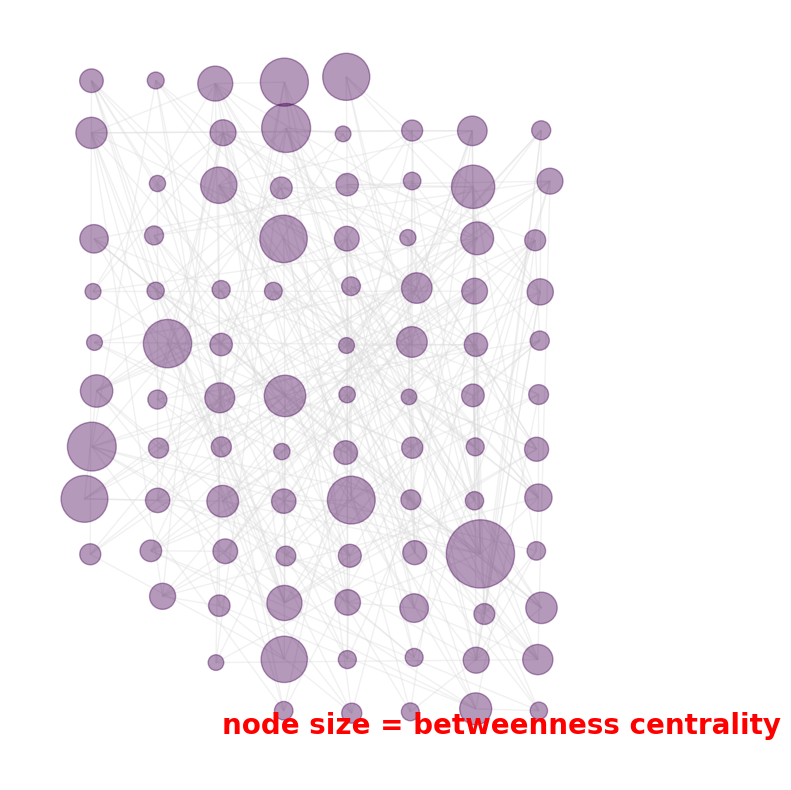

In [58]:
H = G.copy()
H.remove_node(35)
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# # compute community structure
# lpc = nx.community.label_propagation_communities(H)
# community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [0 for n in H]
node_size = [v * 10000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=positions,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "r", "fontweight": "bold", "fontsize": 20}


ax.text(
    0.80,
    0.06,
    "node size = betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

## Fin